# Using Data Science to Cheat at Wordle

Wordle gives you 6 attempts to guess a 5 letter word. This usually involves a bit of luck, as the both the target word and which words you guess play a decisive role in the outcome of the game. I wrote this little project to minimize luck's role in the game, instead relying on a more data driven approach. Full disclosure:  This will take the fun out of Wordle, so I advise you use this tool as a novelty only.

Nota bene:  This project assumes you're playing on hard mode, in which you must utilize letters discovered in full and partial matches. Consequently, the tools here won't work if you don't make use information the game gives you upon each guess, though the general concept is still the same.

In [18]:
import pandas as pd
import numpy as np
import re
import string

### Build a dataframe

We'll use pandas to make a dataframe which will give us a nice boost to our performance (since pure Python is notoriously slow), plus it will greatly simplify a lot of the code we'll need as it applies our functions across the entire dataframe.

First, we need to load the master list.  I don't remember where I found it, but Wordle only has a pool of 2,309 words to choose from, so I've included it as a text file.  We load it up into a DataFrame and set that column as our index, which will be important when we start filtering out words from the pool.

In [14]:
def build_dataframe():
    words = pd.read_csv('word-list.txt', header=None, names=['word'])['word']
    df = pd.DataFrame(index=words)
    return df


df = build_dataframe()

df

""
word
aback
abase
abate
abbey
abbot
...
young
youth
zebra


### Defining our strategy

For this project we'll be using bit entropy to decide which word is the optimal guess.  I'm not making any claim about whether this is the optimal approach for this, but it's relatively fast, the math is easy to understand, and I wrote it in 12 lines of code (not counting comments).

Entropy, in this context, is the amount of uncertainty that exists within a model. We want to minimize entropy as much as possible with each guess. To do that, we want to pick words that will narrow down our remaining word pool as much as possible.  The fewer words we have in our remaining pool, the less uncertainty remains in the model.  When the pool only contains 1 word, there is no uncertainty left, and we've solved the puzzle.

To illustrate this, let's take a look at the likelihood each letter appears in our corpus:

In [29]:
def letter_likelihood(df):
    # likelihood = number of words containing a letter divided by total number of words
    alphabet = string.ascii_lowercase
    likelihood_map = {c: df.filter(regex=c, axis=0).index.size / df.index.size for c in alphabet }
    return {k:v for k,v in sorted(likelihood_map.items(), key=lambda c: c[1], reverse=True)} # sorted most likely to least likely

letter_likelihood(df) 

{'e': 0.4560415764400173,
 'a': 0.3923776526634907,
 'r': 0.3616284105673452,
 'o': 0.2910350801212646,
 't': 0.288869640537029,
 'i': 0.2797747942832395,
 'l': 0.2793417063663924,
 's': 0.267215244694673,
 'n': 0.23733217843222174,
 'u': 0.1974880900822867,
 'c': 0.1931572109138155,
 'y': 0.18016457340840192,
 'h': 0.16327414465136422,
 'd': 0.16024252923343438,
 'p': 0.1494153313122564,
 'g': 0.12949328713728886,
 'm': 0.12906019922044176,
 'b': 0.11520138588133391,
 'f': 0.08921611087050671,
 'k': 0.08748375920311824,
 'w': 0.08358596795149416,
 'v': 0.06409701169337376,
 'x': 0.01602425292334344,
 'z': 0.015158077089649198,
 'q': 0.012559549588566478,
 'j': 0.01169337375487224}

Here we can see that the letter 'e' has a 45.6% chance of appearing in a word, while 'j' only has a just over 1% chance of appearing in a word.

So, if our guess contained the letter 'j' and the target word also contained the letter 'j', then we would eliminate almost 99% of the corpus with just one guess.  However, there's only a 1% chance of that happening. Meanwhile, if we guess the letter 'e', and the target word contains the letter 'e', we're only eliminating 55% of the words, but we can reliably do that 45% of the time.

Okay, so what happens if the target word doesn't contain a letter we guess?  That's informative too. When we guess an incorrect letter, we still eliminate any word which contains that guessed letter, so we're still reducing uncertainty from our model.  When we guess the letter 'e', and an 'e' is not present, we eliminate 45% of the words, and this should happen about 55% of the time.  Meanwhile, if guess the letter 'j', if a 'j' isn't present (i.e. in 99% of words), we only eliminate 1% of the corpus.

So, from this, we should prioritize letters which will eliminate a medium amount of uncertainty, regardless of whether or not the target word contains that letter, over letters which have a small chance to eliminate a large amount of uncertainty but a large chance to eliminate only a small amount of uncertainty.

To quantify this, we can use the following function:

In [35]:
def get_information_content(df, letter):
    total = df.index.size
    included = df.filter(regex=letter, axis=0).index.size # number of words containing a letter
    excluded = total - included # everything else
    return included * excluded / (total / 2) ** 2 # (half the total) squared in the denominator normalizes the values to a range of 0..1


In this function, we're multiplying the number of words in our corpus which include a guessed letter by the number of words which don't. This rewards guesses which which account both for success and for failure.  To normalize everything between a scale of 0 to 1, the product of these two numbers is divided by the half the number of remaining words squared, which represents the ideal information content -- a letter which could eliminate half the corpus regardless of whether it is present in the target word or not.

To illustrate:

In [36]:
print("Information content of 'e': {}", get_information_content(df, 'e'))
print("Information content of 'j': {}", get_information_content(df, 'j'))

Information content of 'e': {} 0.9922706279924847
Information content of 'j': {} 0.04622655506040442


Here we can see that 'e' has a much better information content than 'j'.  'e' has a very nearly perfect information content, at least for our first guess (more on that in a moment).  By guessing 'e', we can consistently eliminate around half of the potential words from our corpus.


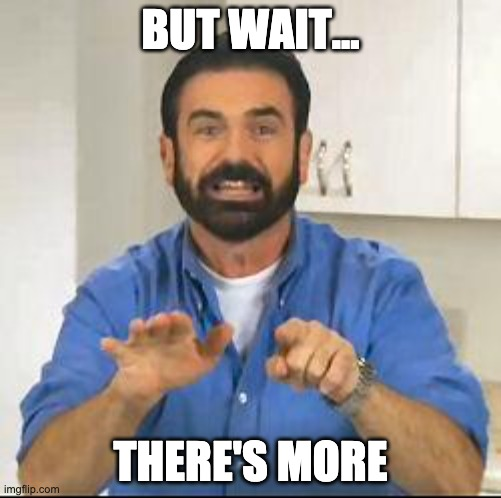

Each guess contains 5 letters!  That means we have 5 opportunities to eliminate words from the corpus with each guess. The effects are compounding. By guessing more letters with higher information content, we can winnow down our list even further, regardless of whether or not those letters are contained within the target word.  To find out which words have the highest information content, we just need to get the information content of each letter in a word, add them up and divide them by 5 (division by 5 is not strictly necessary as it's a scalar operation, but I like to keep my data normalized in the range of 0..1 and dividing by the number of letters does that.  Then we just do that for every word in our corpus, and we can see the words with the most and least information content.

In [37]:
def score_word(df, word):
    # Repeated letters can yield a little extra information, but not so much that it was worth coding up, 
    # so I'll penalize repeated letters here by casting the letters into a set, so only unique letters are scored.
    return sum([get_information_content(df, c) for c in set(word)]) / 5
    
def score_remaining_words(df):
    df2 = df.copy()
    df2['score'] = [score_word(df, word) for word in df.index]
    return df2.sort_values(by='score', ascending=False, axis=0)

score_remaining_words(df)

,score
word,
irate,0.899411
alter,0.899258
alert,0.899258
later,0.899258
arose,0.895587
...,...
civic,0.333870
jazzy,0.330086
fuzzy,0.321901


Here we can see the information content in action.  'Irate' and 'alter' (along with various anagrams thereof) have an information content of 0.89, which is to be expected if we look back at the likelihood of letters appearing in our word list.  All of the letters in those two words are quite common, appearing towards the top of our list. Meanwhile, words like 'mamma', and 'vivid' have lower scores due to their repeat letters, and 'jazzy' and 'fuzzy' having lower scores for using less common letters like 'z' and 'j'.

From this, 'irate' is the optimal first guess. Now let's apply this theory with an actual game.

First, we'll need one more function, which will pare down our word list appropriately as we continue guess. Below is the function which will accomplish that. It takes a wordlist, our guessed word, and the results of that guess. Then it filters out words according to the results of the guess and returns a new wordlist which contains only words which have yet to be eliminated.  I had to come up with my own notation for the results, so I used the following:

. = unmatched letter -- the target word does not contain this letter (gray in the game)
x = partial match -- the target word contains this letter but not in this position (yellow in the game)
X = match -- the target word contains this letter in this position (green in the game)

In [38]:
def guess(df, word, result):
    try:
        assert(re.match(r'[a-z]{5}', word))
        assert(re.match(r'[.xX]{5}', result))
        
        for w, r, i in zip(word, result, range(0,5)):
            if r == ".":
                # Filter out words containing an unmatched letter
                pattern = f"^((?!{w}).)*$"
            if r == "x":
                # Filter out words with a partially matched letter in the guessed position
                pattern = "." * i + f"[^{w}]" + "." * (4 - i)
                df = df.filter(regex=w, axis=0)
            if r == "X":
                # Only include words with matched letters in the correct position
                pattern = "." * i + w + "." * (4 - i)
            df = df.filter(regex=pattern, axis=0)
        return df
    except AssertionError as ae:
        print(ae)

,score
word,
bison,0.0


For the first word, we will, of course, guess 'irate', as it has the maximum information content:

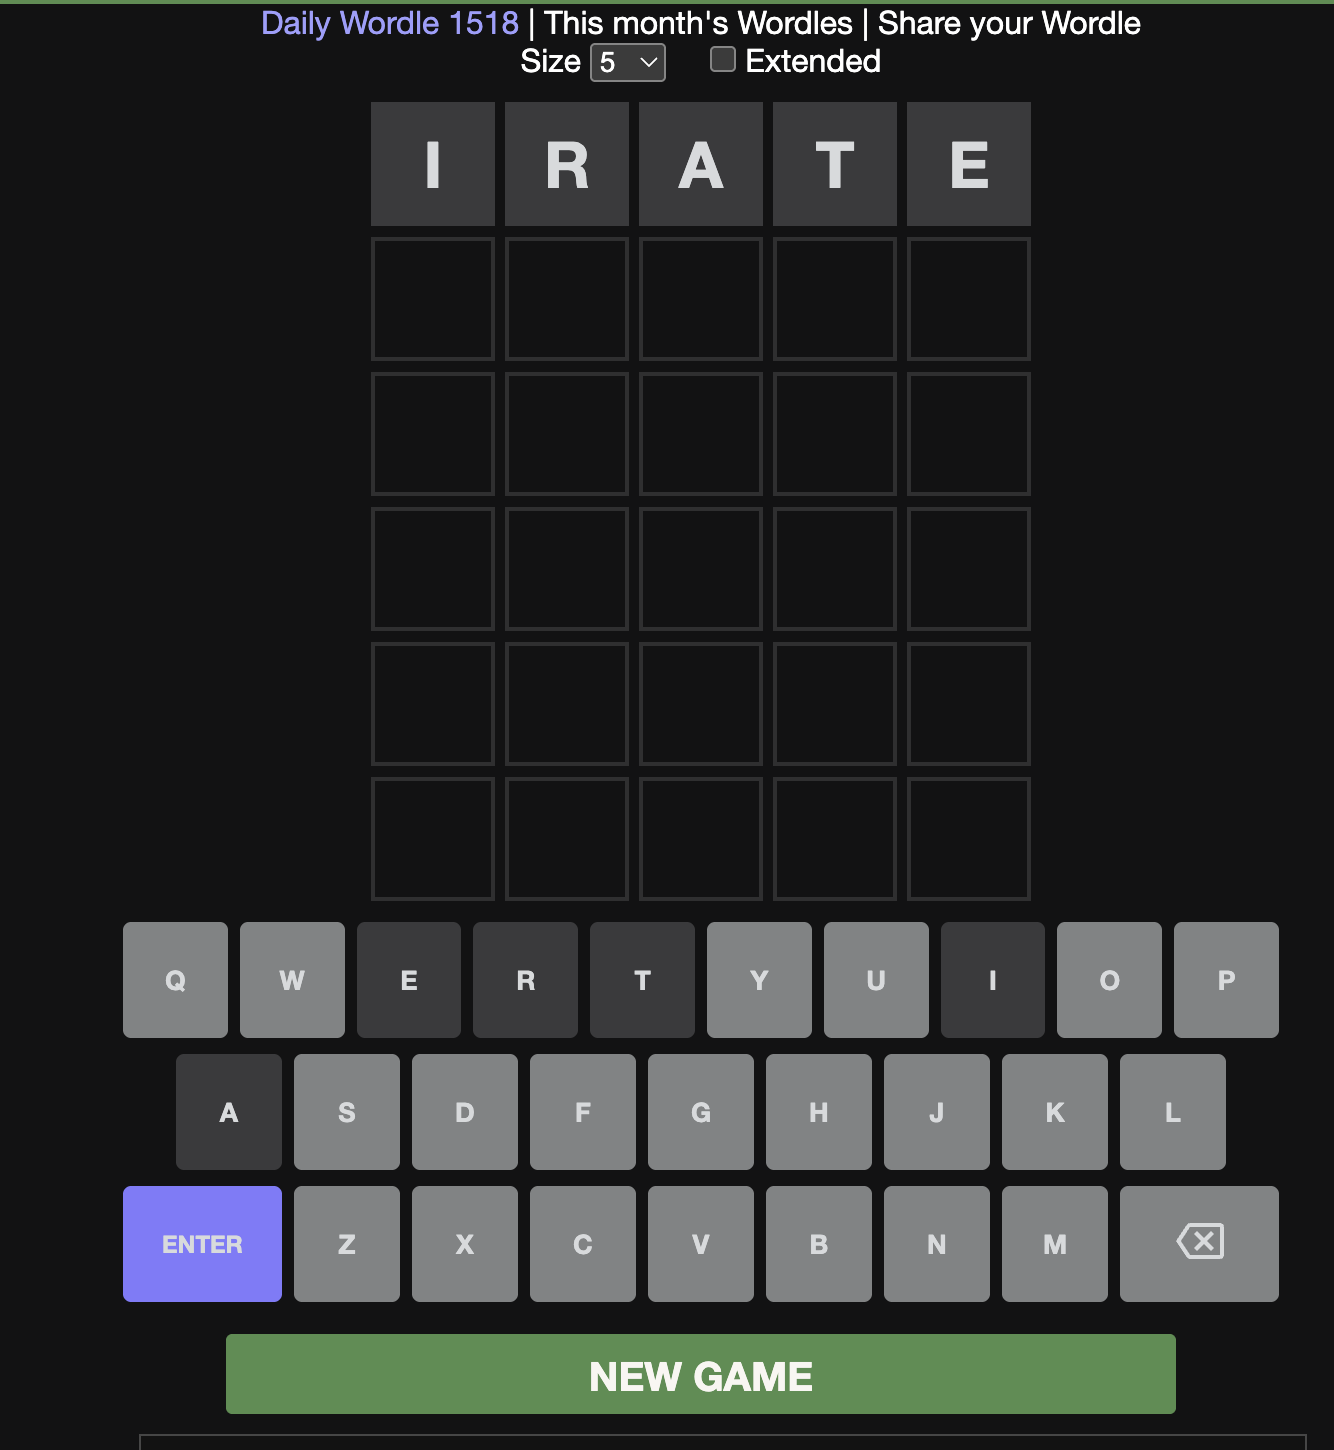

Weirdly, despite using the most frequently appearing letters, none of them were matches! But that doesn't mean that our attempt was unsuccessful.  It's still quite informative.

In [43]:
df2 = guess(df, "irate", ".....") # 'irate' had no matches
score_remaining_words(df2)

,score
word,
lousy,0.967672
locus,0.914838
sulky,0.886145
pushy,0.864968
plush,0.861747
...,...
bobby,0.500717
booby,0.500717
fuzzy,0.495863


We went from 2309 words to just 193, a 91% reduction!  And now, we also have a new top word for information content: 'lousy', with a whopping IC of 0.97. Again, notice how uncommon letters and repeats are pushed towards the bottom as being less informative.  They are unreliable and not worth spending a guess on. We will next guess 'lousy', but first, let's take a look at the information content of each letter within our new list:

In [46]:
def alphabet_ic(df):
    alphabet = string.ascii_lowercase
    ic = {c: get_information_content(df, c) for c in alphabet}
    return {k:v for k,v in sorted(ic.items(), key=lambda c: c[1], reverse=True)}

alphabet_ic(df2)

{'u': 0.9922414024537571,
 'y': 0.9903084646567694,
 'o': 0.9881607559934494,
 'l': 0.9742006496818707,
 's': 0.8934468039410454,
 'n': 0.7967999140916535,
 'h': 0.7678058471368359,
 'c': 0.7261402990684314,
 'p': 0.6810384171387152,
 'm': 0.6198287202341003,
 'd': 0.6069424682541813,
 'k': 0.5805256516953475,
 'b': 0.5251147681816961,
 'g': 0.5251147681816961,
 'f': 0.43555531692125965,
 'w': 0.3878761845955596,
 'j': 0.06120969690461489,
 'z': 0.06120969690461489,
 'v': 0.02061800316787028,
 'x': 0.02061800316787028,
 'a': 0.0,
 'e': 0.0,
 'i': 0.0,
 'q': 0.0,
 'r': 0.0,
 't': 0.0}

Notice how 'e' dropped from an IC of 0.992 to an IC of 0.0!  Because 'e' wasn't present in the target word, all words with the letter 'e' have been removed. 'e' no longer has any information to yield, as we are 100% certain that our target word does not have an 'e'.  The same would have also been true if 'e' had been a match -- all remaining words would have contained an 'e', so 'e' still would not have possessed any interesting information.

Okay.  Onto our guess:

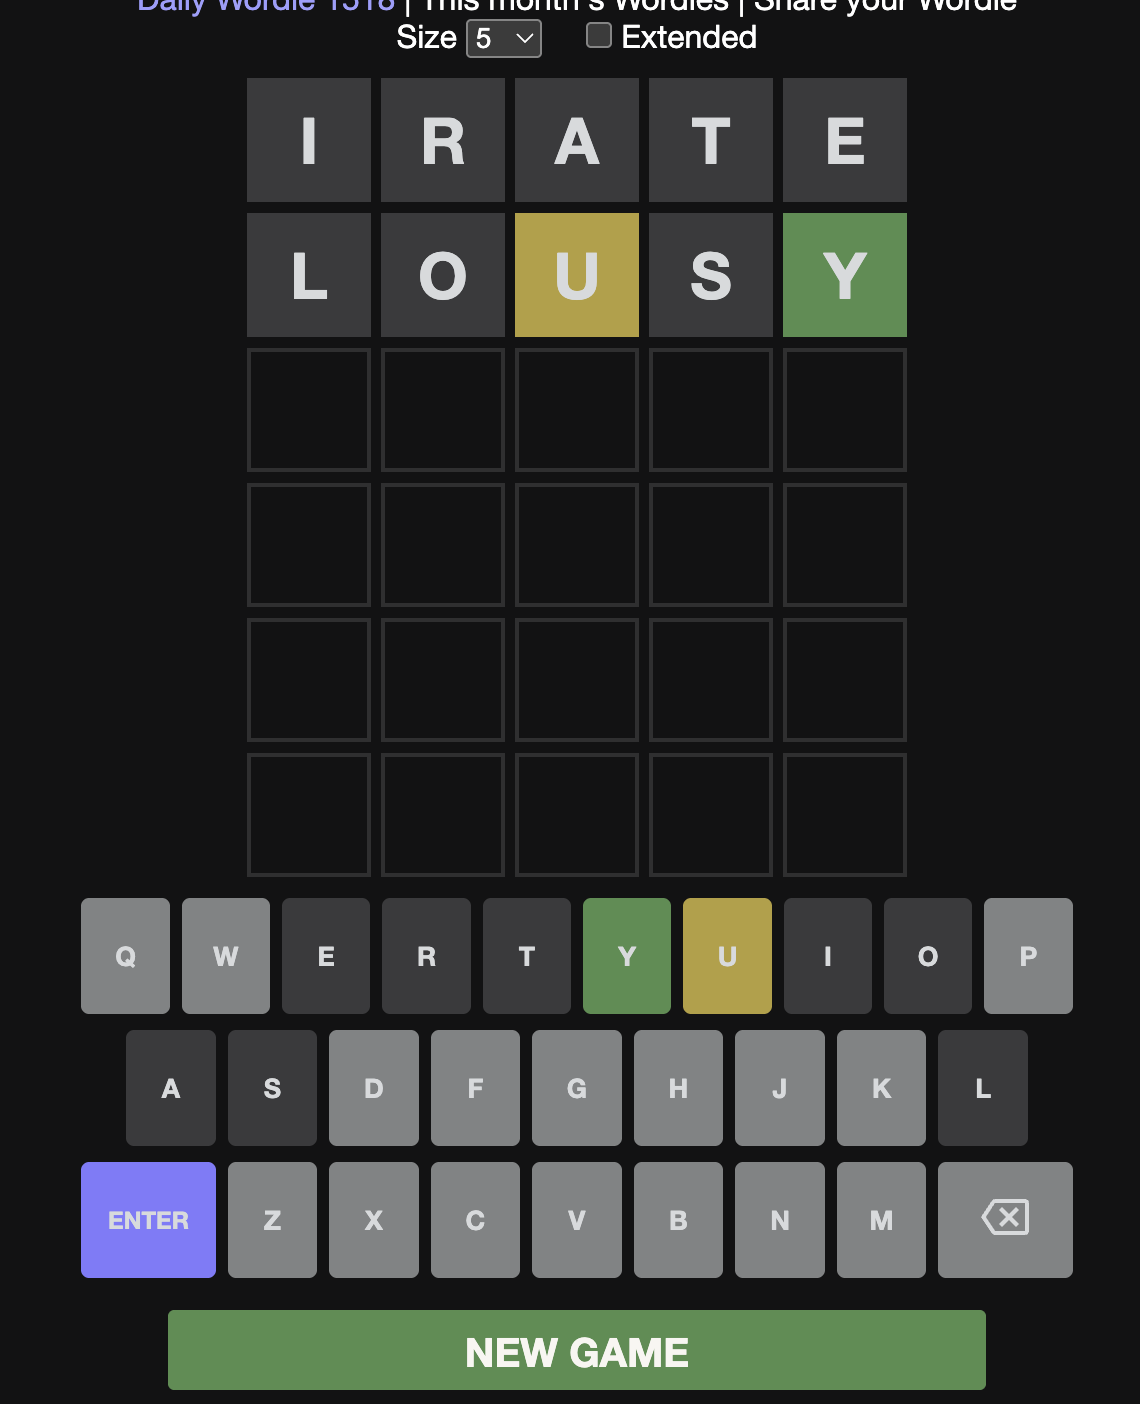

We had a partial match in the third position with 'u' and a full match with 'y' in the 5th position. Let's see how that affects our remaining word list:

In [49]:
df3 = guess(df2, 'lousy', '..x.X')
score_remaining_words(df3)

,score
word,
dumpy,0.531856
pudgy,0.478670
jumpy,0.398892
funky,0.372299
mucky,0.367867
dummy,0.359003
muddy,0.359003
duchy,0.323546
gummy,0.319114


Again, a ~90% reduction in word count.  However, notice now that our IC scores have taken a dive -- whereas we had upper 0.80s to 0.99 previously, now our highest scoring word is 'dumpy' with a paltry 0.53.  That's because there's less overall information to reveal at this point. We know there's a 'u' (apparently in the second position, given the remaining list), and we know there's a 'y', neither of which have any information content left to yield, and since we're playing on hard mode, we must use them, so we're losing out on two letters' worth of information content.  Okay, so let's play 'dumpy':

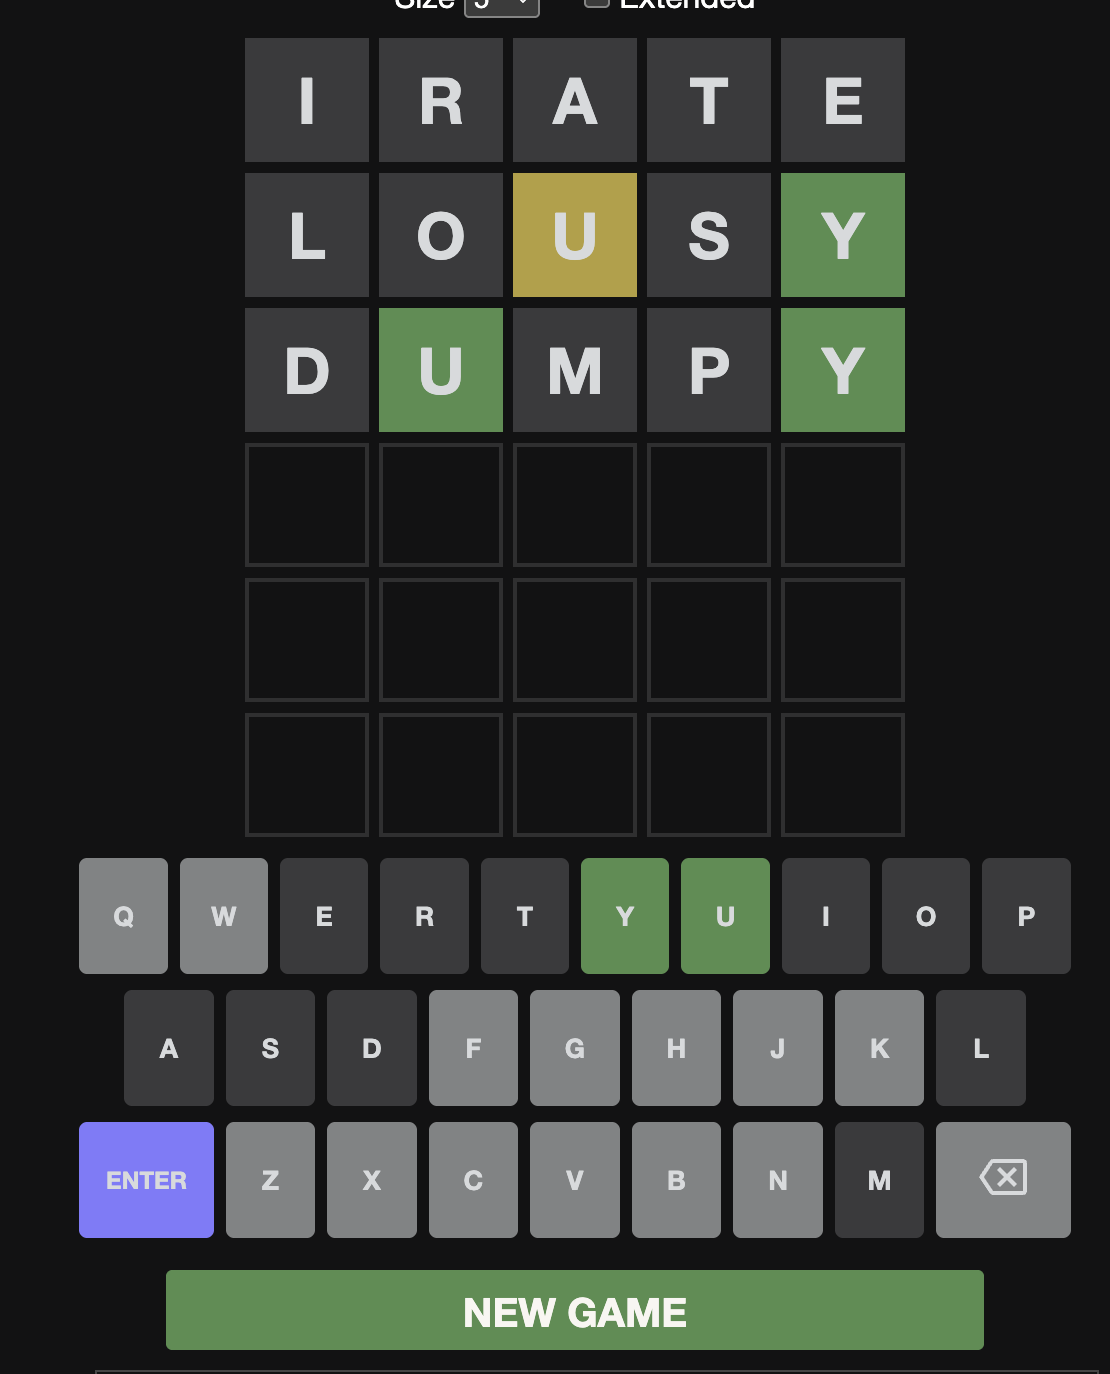

You know the drill:

In [50]:
df4 = guess(df3, 'dumpy', '.X..X')
score_remaining_words(df4)

,score
word,
funky,0.555556
hunky,0.466667
funny,0.377778
bunny,0.355556
fuzzy,0.311111
buggy,0.288889


We didn't lose nearly as many words this time, proportionally, which meaks sense given the anemic IC scores we saw -- there's just not as much information to resolve at this point.

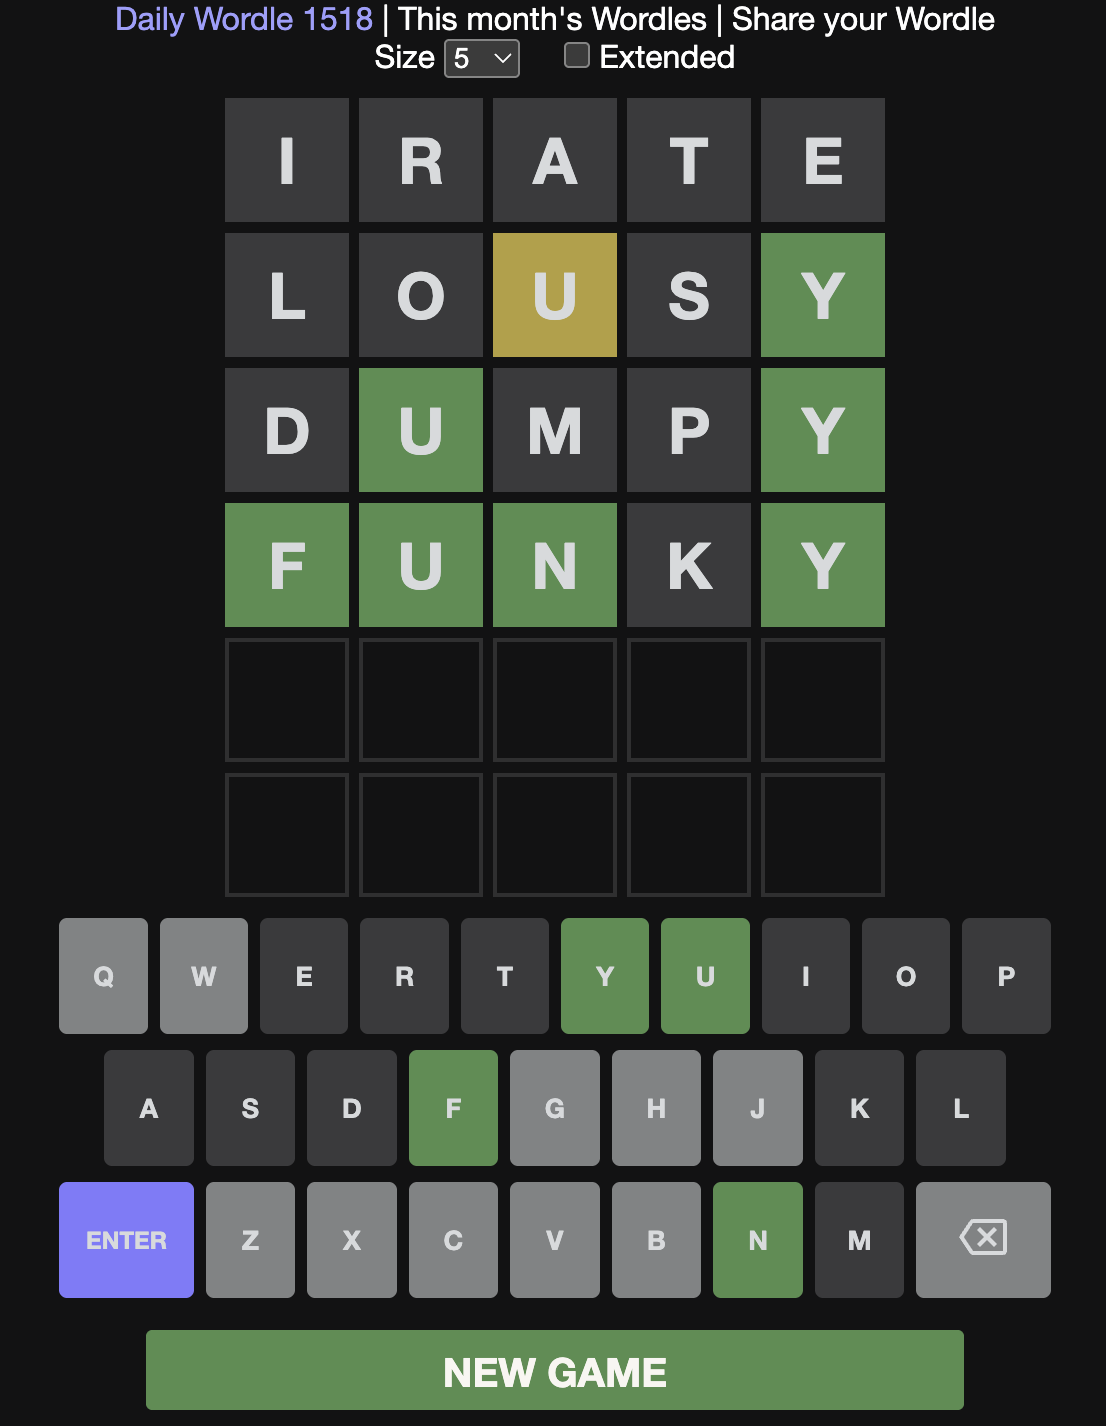

In [52]:
df5 = guess(df4, 'funky', 'XXX.X')
score_remaining_words(df5)

,score
word,
funny,0.0


I wonder what it could be...

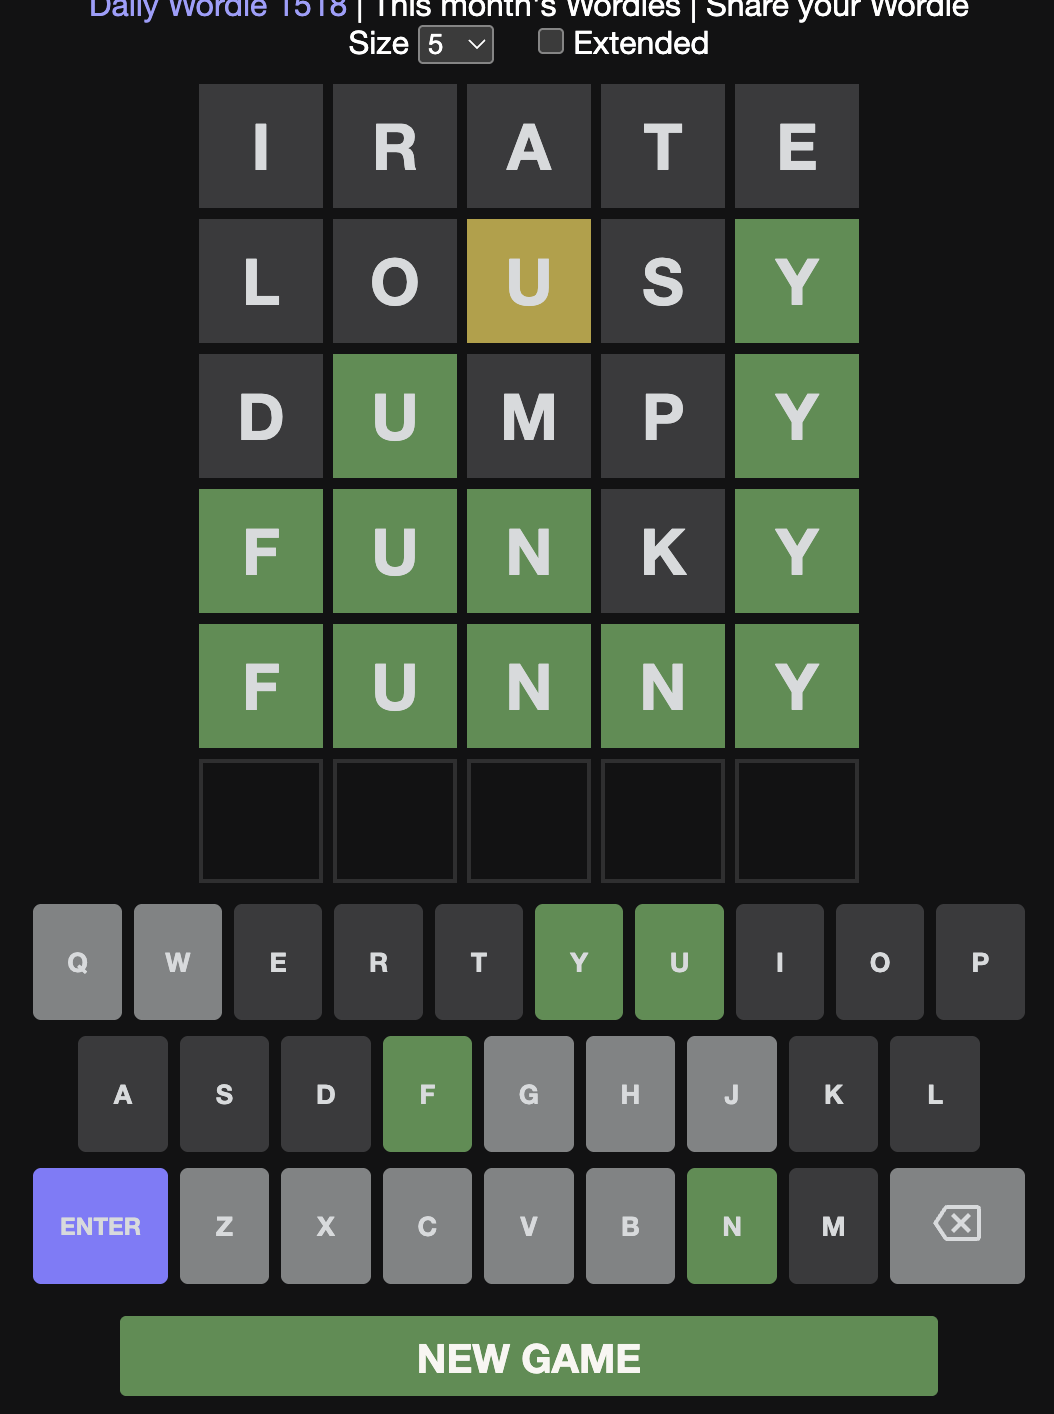

Notice how 'funny' has a score of 0.0.  This is because we are now certain that the word is 'funny', so guessing it doesn't yield any new information.

Let's play again, using the same strategy, but this time I'll skip the screenshots and just show the results using the guess and score_remaining_words functions:

In [53]:
df2 = guess(df, 'irate', '.x...')
score_remaining_words(df2)

,score
word,
scour,0.679817
curly,0.664338
surly,0.664338
hydro,0.650148
corny,0.650148
...,...
fjord,0.417522
juror,0.408492
floor,0.392153


In [55]:
df3 = guess(df2, 'scour', 'x..xx')
score_remaining_words(df3)

,score
word,
usurp,0.0


Okay, one more, this time in the pessimal case, where we use the *least* informative word at each step:

In [56]:
df2 = guess(df, 'mamma', '.....')
score_remaining_words(df2)

,score
word,
store,0.907783
route,0.897896
outer,0.897896
tenor,0.897896
inter,0.896511
...,...
puppy,0.384701
queue,0.365885
fuzzy,0.365394


In [57]:
df3 = guess(df2, 'vivid', '.....')
score_remaining_words(df3)

,score
word,
rouse,0.965623
store,0.959124
route,0.956978
outer,0.956978
torus,0.943981
...,...
booby,0.430673
fluff,0.425088
woozy,0.424313


In [58]:
df4 = guess(df3, 'queue', '.....')
score_remaining_words(df4)

,score
word,
crypt,0.810694
story,0.773469
short,0.756490
snort,0.748776
shorn,0.735551
...,...
woozy,0.354041
poppy,0.339224
boozy,0.323347


In [60]:
df5 = guess(df4, 'bobby', '.x...')
score_remaining_words(df5)

,score
word,
snort,0.748199
scorn,0.732477
shorn,0.732477
short,0.728042
sworn,0.726430
...,...
known,0.467624
whoop,0.460771
clock,0.459158


In [62]:
df6 = guess(df5, 'gloss', '..X..')
score_remaining_words(df6)

,score
word,
frock,0.739556
front,0.725333
thorn,0.725333
crown,0.718222
froth,0.711111
frown,0.704000
knock,0.576000
chock,0.561778
crock,0.561778


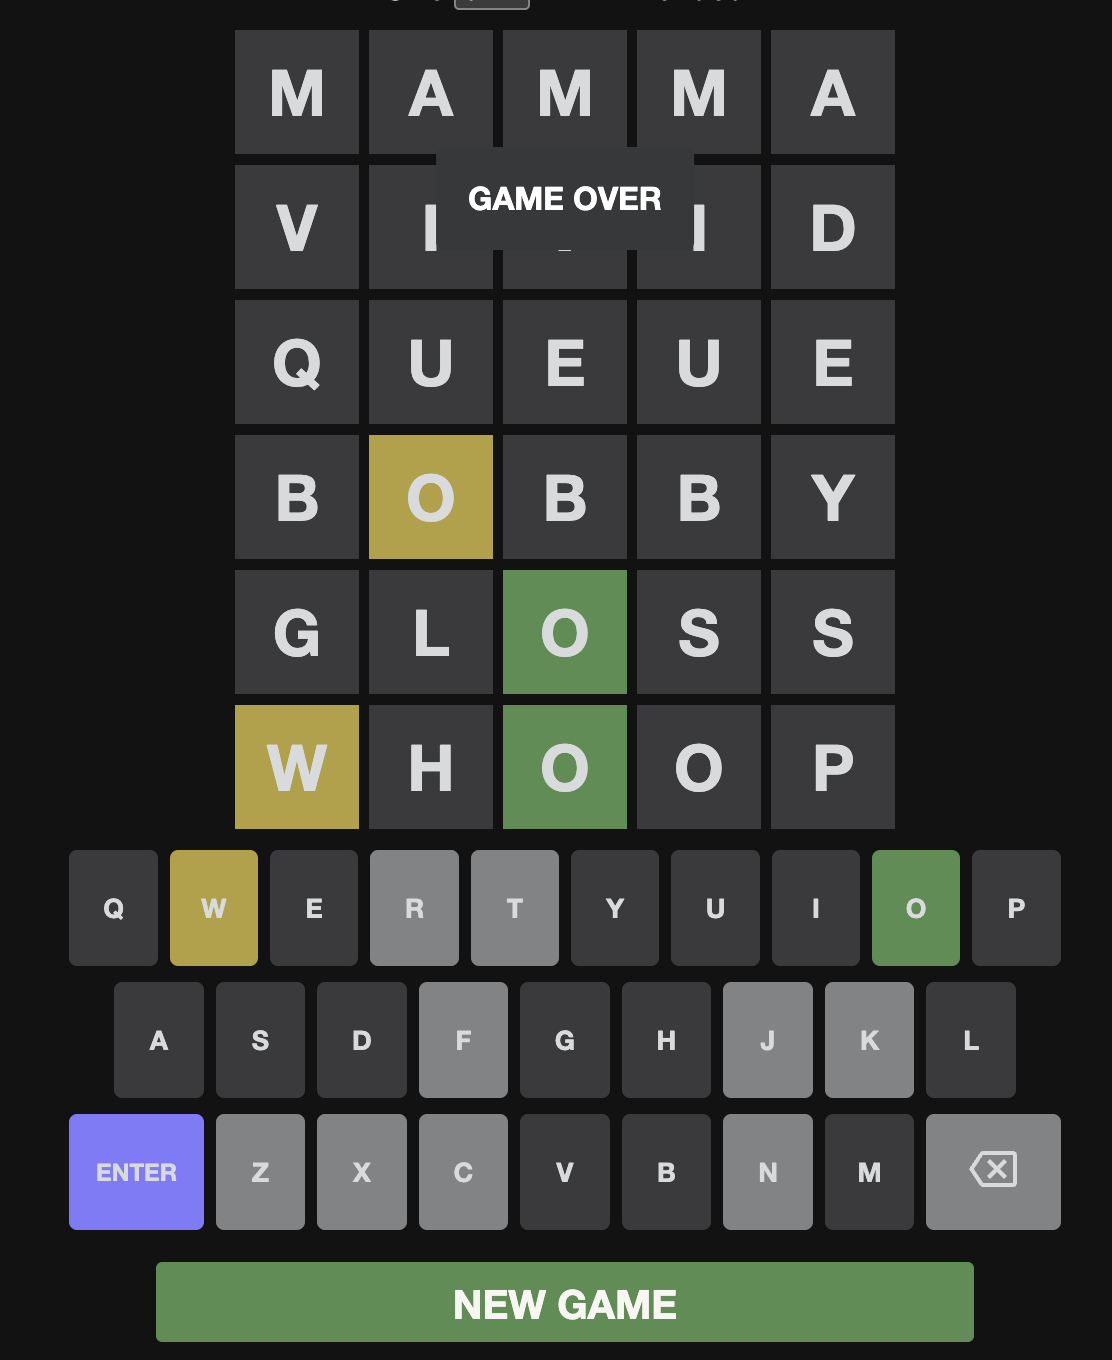